In [1]:
import os 
import pandas as pd 
os.listdir('/kaggle/input') 
media_path = "/kaggle/input/media-coverage-speeches-unmerged"
speeches = pd.read_csv(f"{media_path}/full_data_updated_24.csv")
news = pd.read_csv(f"{media_path}/full_mediacoverage_preprocessed.csv")

In [3]:
print(speeches.columns)
print(speeches.head())
print(news.columns)
print(news.head())
print(speeches.shape)
print(news.shape)

Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date'], dtype='object')
   Unnamed: 0  X  speech_id  \
0           1  1          1   
1           2  2          2   
2           3  3          3   
3           4  4          4   
4           5  5          5   

                                               title  \
0  Versión estenográfica de la conferencia de pre...   
1  Versión estenográfica de la conferencia de pre...   
2  Versión estenográfica. Aniversario de la Huelg...   
3  Versión estenográfica. Programas para el Biene...   
4  Versión estenográfica. Programas para el Biene...   

                                                urls  \
0  https://lopezobrador.org.mx/2024/01/09/version...   
1  https://lopezobrador.org.mx/2024/01/08/version...   
2  https://lopezobrador.org.mx/2024/01/07/version...   
3  https://lopezobrador.org.mx/2024/01/06/version...   
4  https://lopezobrador.org.mx/2024/01/06/version...   

                                             co

In [5]:
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 70.2 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
import nltk
import spacy
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
spanish_stopwords_nltk = set(stopwords.words('spanish'))

# Load SpaCy Spanish stopwords
nlp = spacy.load("es_core_news_sm")
spanish_stopwords_spacy = nlp.Defaults.stop_words

# Add your own custom stopwords
custom_stop_words = [
    'presidente', 'andrés', 'méxico', 'lópez', 'obrador',
    'manuel', 'pesos', 'mil', 'año', 'caso'
]

# Merge all into a single set
all_stopwords = spanish_stopwords_nltk.union(spanish_stopwords_spacy).union(set(custom_stop_words))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess_text(text):
    words = text.lower().split()
    words = [re.sub(r'\W+', '', w) for w in words if w not in all_stopwords]
    return ' '.join(words)

# Apply to full speech/news datasets
speeches['clean_content'] = speeches['content'].apply(preprocess_text)
news['clean_content'] = news['Content'].apply(preprocess_text)

import numpy as np

def parse_embeddings(df, column_name):
    return np.vstack(
        df[column_name].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
    )

# Only needed if embeddings are available as strings
# speech_embeddings_np = parse_embeddings(speeches, 'speech_embeddings')
# news_embeddings_np = parse_embeddings(news, 'news_embeddings')


In [18]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(
    '/kaggle/input/sentence-transformer-esp/sentence_similarity_spanish_es',
    device='cuda'  # Use GPU
)


In [12]:
!pip install bertopic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00


In [95]:

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan

# Combine SpaCy + your custom stopwords
import spacy
nlp = spacy.load("es_core_news_sm")
custom_stop_words = ['presidente', 'andrés', 'méxico', 'lópez', 'obrador',
                     'manuel', 'pesos', 'mil', 'año', 'caso','contenido relacionado','cd','mandamos correo','lunes','mandamos','correo'
                     'martes','miércoles','viernes','sábado','sabado','domingo','contenido relacionado','contenido','necesita periodismo',
                    'señor','pregunta','01','importante','pueblo','libre','necesita','hrs','13','16','990','cable',
                    'news','cable news','network','copyright','multimedia','multimedios','2024','2025','2023','2022','2021','2020','2019','2018',
                    'association','publicado','dof','laiman','000','discovery','company','amlo','gobierno nacional','años','mandatario','país','pais',
                    'lã³pez','mintiã³','aã','paã'
                    ]
stopwords = list(nlp.Defaults.stop_words.union(set(custom_stop_words)))

vectorizer_model = CountVectorizer(
    stop_words=stopwords,
    ngram_range=(1, 2),
    min_df=1
)

umap_model = UMAP(n_components=3, n_neighbors=100, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=50, metric='euclidean', prediction_data=True)

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    nr_topics=10,
    low_memory=False, #We can add probabilities of topic p document
    calculate_probabilities = True
)


In [96]:
print(speeches.columns)

Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'clean_content', 'topic', 'speech_date', 'month'],
      dtype='object')


In [97]:
speech_texts = speeches["clean_content"].tolist()
news_texts = news["processed_content"].tolist()

# Combine speech and news texts
all_texts = speech_texts + news_texts

# Fit the model on all texts (speeches and news)
all_topics, _ = topic_model.fit_transform(all_texts)

# Split the topics back into speeches and news
speech_topics = all_topics[:len(speech_texts)]
news_topics = all_topics[len(speech_texts):]

# Add the topic results back to the DataFrames
speeches["topic"] = speech_topics
news["topic"] = news_topics


In [98]:
# Get the topics and their frequencies in speeches
speech_topic_freq = topic_model.get_topic_info()
print(speech_topic_freq.head())

# Get the topics and their frequencies in news articles
news_topic_freq = topic_model.get_topic_info()
print(news_topic_freq.head())


   Topic  Count                                               Name  \
0     -1  17484             -1_gobierno_nacional_millones_política   
1      0  19110                    0_gobierno_mã_nacional_millones   
2      1   1185  1_correo resumen_conversación correo_quedas co...   
3      2    304  2_jueves_espera inflación_perspectiva banco_pu...   
4      3    168               3_periodismo periodismo_periodismo__   

                                      Representation  \
0  [gobierno, nacional, millones, política, feder...   
1  [gobierno, mã, nacional, millones, unidos, gen...   
2  [correo resumen, conversación correo, quedas c...   
3  [jueves, espera inflación, perspectiva banco, ...   
4  [periodismo periodismo, periodismo, , , , , , ...   

                                 Representative_Docs  
0  [inicio a-interna semana empresarios expreside...  
1  [2022 ricardo flores magón precursor revolució...  
2  [amlo presenta programas integrales bienestar ...  
3  [indicadores import

In [99]:
# Get the topics and their frequencies
topic_info = topic_model.get_topic_info()

# Display the topic information
print(topic_info.head())

# Get the top words for each topic
# Get the top words for each topic and display the top 10
for topic_id in topic_info['Topic']:
    if topic_id != -1:  # Ignore noise topics (if any)
        topic_words = topic_model.get_topic(topic_id)
        # Display the top 10 words
        print(f"Topic {topic_id}:")
        for word, weight in topic_words[:10]:
            print(f"  - {word}: {weight}")
        print("\n")


   Topic  Count                                               Name  \
0     -1  17484             -1_gobierno_nacional_millones_política   
1      0  19110                    0_gobierno_mã_nacional_millones   
2      1   1185  1_correo resumen_conversación correo_quedas co...   
3      2    304  2_jueves_espera inflación_perspectiva banco_pu...   
4      3    168               3_periodismo periodismo_periodismo__   

                                      Representation  \
0  [gobierno, nacional, millones, política, feder...   
1  [gobierno, mã, nacional, millones, unidos, gen...   
2  [correo resumen, conversación correo, quedas c...   
3  [jueves, espera inflación, perspectiva banco, ...   
4  [periodismo periodismo, periodismo, , , , , , ...   

                                 Representative_Docs  
0  [inicio a-interna semana empresarios expreside...  
1  [2022 ricardo flores magón precursor revolució...  
2  [amlo presenta programas integrales bienestar ...  
3  [indicadores import

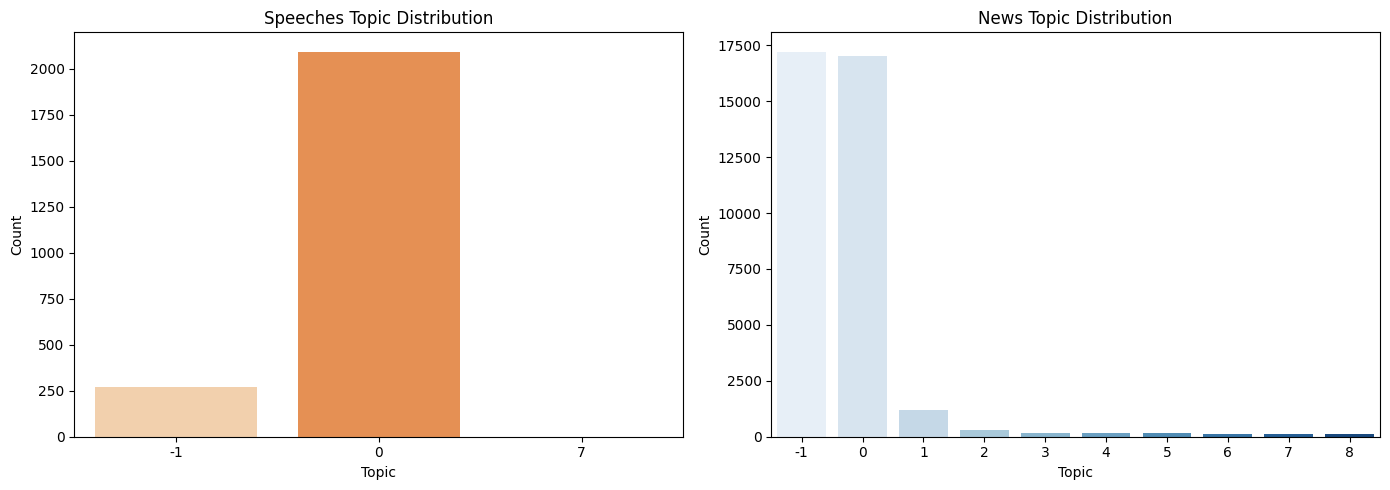

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each topic in speeches and news
speech_topic_counts = speeches["topic"].value_counts()
news_topic_counts = news["topic"].value_counts()

# Plot the topic distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=speech_topic_counts.index, y=speech_topic_counts.values, ax=ax[0], palette="Oranges")
ax[0].set_title("Speeches Topic Distribution")
ax[0].set_xlabel("Topic")
ax[0].set_ylabel("Count")

sns.barplot(x=news_topic_counts.index, y=news_topic_counts.values, ax=ax[1], palette="Blues")
ax[1].set_title("News Topic Distribution")
ax[1].set_xlabel("Topic")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


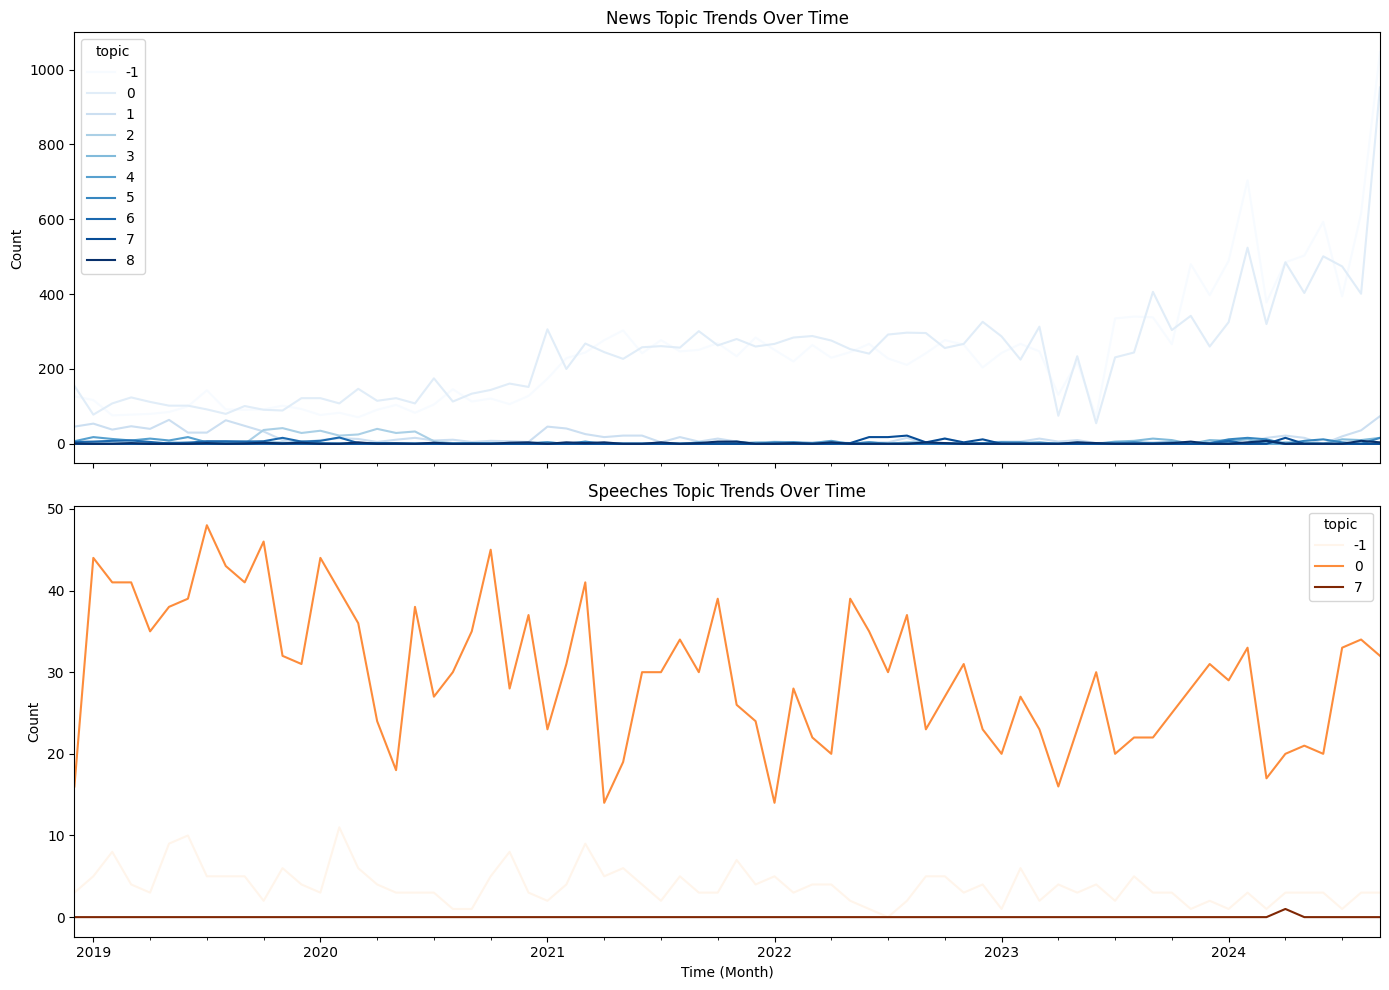

In [101]:
# Assuming your speeches and news DataFrames have date columns
# For speeches
speeches['speech_date'] = pd.to_datetime(speeches['date'])
speeches['month'] = speeches['speech_date'].dt.to_period('M')

# For news
news['news_date'] = pd.to_datetime(news['Date'])
news['month'] = news['news_date'].dt.to_period('M')

# Group by month and topic
speech_topic_trends = speeches.groupby(['month', 'topic']).size().unstack(fill_value=0)
news_topic_trends = news.groupby(['month', 'topic']).size().unstack(fill_value=0)

# Plot topic trends over time
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot news topic trends
news_topic_trends.plot(ax=ax[0], cmap="Blues")
ax[0].set_title("News Topic Trends Over Time")
ax[0].set_ylabel("Count")

# Plot speech topic trends
speech_topic_trends.plot(ax=ax[1], cmap="Oranges")
ax[1].set_title("Speeches Topic Trends Over Time")
ax[1].set_ylabel("Count")

plt.xlabel("Time (Month)")
plt.tight_layout()
plt.show()


In [102]:
# Get the topics assigned to each document
speech_topics, _ = topic_model.transform(speech_texts)
news_topics, _ = topic_model.transform(news_texts)

# Create a DataFrame with the topics and dates for speeches
speech_data = speeches[['date']].copy()
speech_data['topic'] = speech_topics

# Convert the 'date' column to datetime (if not already)
speech_data['date'] = pd.to_datetime(speech_data['date'])

# Group by date to see the distribution of topics over time
topic_counts_speech = speech_data.groupby([speech_data['date'].dt.to_period('M'), 'topic']).size().reset_index(name='count')

# Plot or analyze the distribution of topics over time
import matplotlib.pyplot as plt
for topic in topic_counts_speech['topic'].unique():
    topic_df = topic_counts_speech[topic_counts_speech['topic'] == topic]
    plt.plot(topic_df['date'].dt.to_timestamp(), topic_df['count'], label=f"Topic {topic}")

plt.xlabel('Date')
plt.ylabel('Topic Frequency')
plt.title('Topic Distribution Over Time')
plt.legend()
plt.show()

# Do the same for news articles
news_data = news[['Date']].copy()
news_data['topic'] = news_topics
news_data['Date'] = pd.to_datetime(news_data['Date'])

topic_counts_news = news_data.groupby([news_data['Date'].dt.to_period('M'), 'topic']).size().reset_index(name='count')

# Plot or analyze the distribution of topics over time
for topic in topic_counts_news['topic'].unique():
    topic_df = topic_counts_news[topic_counts_news['topic'] == topic]
    plt.plot(topic_df['Date'].dt.to_timestamp(), topic_df['count'], label=f"Topic {topic}")

plt.xlabel('Date')
plt.ylabel('Topic Frequency')
plt.title('Topic Distribution Over Time (News)')
plt.legend()
plt.show()


KeyboardInterrupt: 

In [ ]:
# Visualize topics
topic_model.visualize_topics()


In [28]:
# Topic assignments for speeches
print(speech_topics[:10])

# Topic assignments for news articles
print(news_topics[:10])


[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 2, 0, -1, 0, -1, -1, 0, 0]


### now we change the logic. Instead of mixing everything and inferring topics from this mixture, we will first train bertopic on speeches and then use this to classify news articles in these predefined speech topics. 

In [113]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan
import spacy
import pandas as pd

# 🔹 Load Spanish NLP model
nlp = spacy.load("es_core_news_sm")

# 🔹 Define stopwords (custom + SpaCy)
custom_stop_words = [
    'presidente', 'andrés', 'méxico', 'lópez', 'obrador', 'manuel', 'pesos', 'mil', 'año', 'caso', 'contenido relacionado',
    'cd', 'mandamos correo', 'lunes', 'mandamos', 'correo', 'martes', 'miércoles', 'viernes', 'sábado', 'sabado', 'domingo',
    'necesita periodismo', 'señor', 'pregunta', '01', 'importante', 'pueblo', 'libre', 'necesita', 'hrs', '13', '16', '990',
    'cable', 'news', 'cable news', 'network', 'copyright', 'multimedia', 'multimedios', '2024', '2025', '2023', '2022', 
    '2021', '2020', '2019', '2018', 'association', 'publicado', 'dof', 'laiman', '000', 'discovery', 'company', 'amlo',
    'gobierno nacional', 'años', 'mandatario', 'país', 'pais', 'lã³pez', 'mintiã³', 'aã', 'paã'
]
stopwords = list(nlp.Defaults.stop_words.union(set(custom_stop_words)))

# 🔹 Vectorization model
vectorizer_model = CountVectorizer(
    stop_words=stopwords,
    ngram_range=(1, 2),
    min_df=1
)

# 🔹 Dimensionality reduction and clustering models
umap_model = UMAP(n_components=5, n_neighbors=10, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10, metric='euclidean', prediction_data=True)

# 🔹 Initialize BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,  # Ensure `embedding_model` is defined
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    nr_topics=10,
    low_memory=False,
    calculate_probabilities=True
)

# 🔹 Train on speech texts
speech_texts = speeches["content"].tolist()
speech_topics, speech_probs = topic_model.fit_transform(speech_texts)

# 🔹 Store topics in the DataFrame
speeches["topic"] = speech_topics
speeches["topic_prob"] = speech_probs.max(axis=1)

In [114]:
# 🔹 Get top 10 words per topic
top_words_per_topic = topic_model.get_topic_info()

# 🔹 Extract the top 10 words per topic
topic_words = {}
for topic in top_words_per_topic["Topic"]:
    if topic == -1:  # Skip outlier topics
        continue
    words = topic_model.get_topic(topic)
    topic_words[topic] = [word[0] for word in words[:10]]

# 🔹 Convert to DataFrame for visualization
top_words_df = pd.DataFrame.from_dict(topic_words, orient="index", columns=[f"Word_{i+1}" for i in range(10)])
top_words_df.index.name = "Topic"
top_words_df.reset_index(inplace=True)

# 🔹 Display DataFrame
top_words_df


,Topic,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10
0,0,gobierno,millones,gente,jóvenes,programa,corrupción,ciento,apoyo,bienestar,salud
1,1,gobierno,nacional,seguridad,millones,gracias,gente,tema,ciento,unidos,general
2,2,salud,personas,gobierno,ciento,millones,hospitales,gracias,covid,semana,médicos
3,3,centavos,precio,gobierno,tren,litro,ciento,semana,gas,gente,maya
4,4,gobierno,gente,millones,interlocutora,interlocutor,unidos,tema,información,tiempo,corrupción
5,5,gobierno,independencia,millones,juárez,pueblos,viva,transformación,revolución,madero,nacional
6,6,fiscalía,personas,seguridad,nacional,millones,proceso,general,gobierno,delito,secretaría
7,7,nacional,guardia,guardia nacional,seguridad,secretaría,defensa,gobierno,elementos,pública,aeropuerto
8,8,millones,salud,dosis,gracias,personas,ciento,gobierno,vacunas,nacional,vacunación


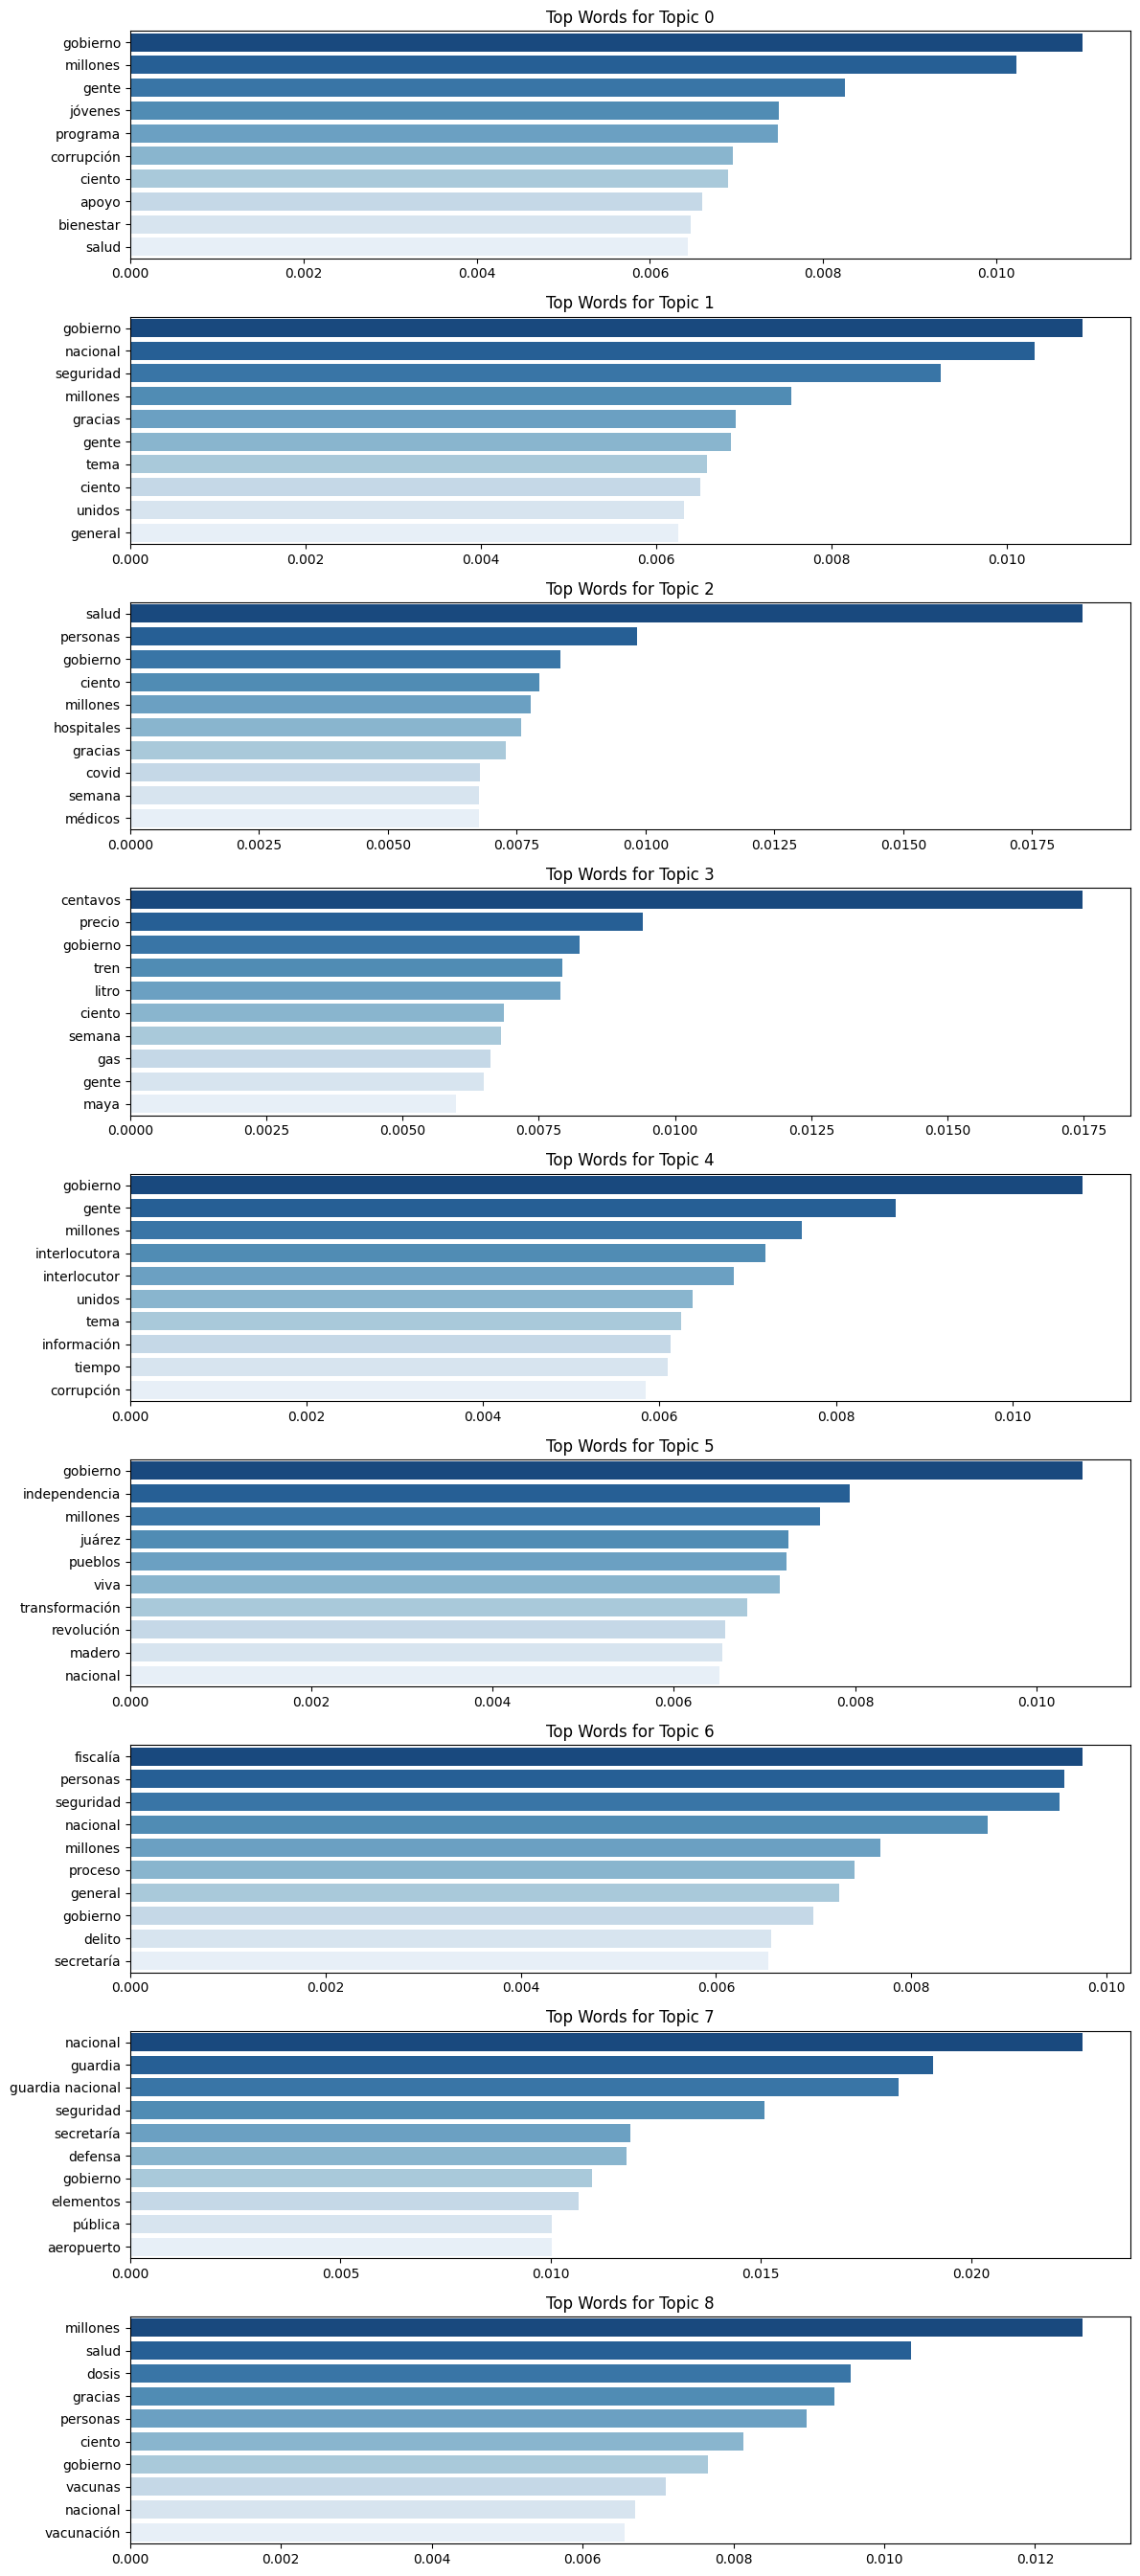

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Select number of topics to display
num_topics_to_plot = min(10, len(topic_words))  # Plot max 10 topics

# 🔹 Create subplots
fig, axes = plt.subplots(num_topics_to_plot, 1, figsize=(12, num_topics_to_plot * 3))

for idx, (topic, words) in enumerate(topic_words.items()):
    if idx >= num_topics_to_plot:
        break  # Stop after 10 topics
    
    # 🔹 Extract words and frequencies
    word_freqs = topic_model.get_topic(topic)
    words = [wf[0] for wf in word_freqs[:10]]
    freqs = [wf[1] for wf in word_freqs[:10]]

    # 🔹 Create bar plot
    sns.barplot(x=freqs, y=words, ax=axes[idx], palette="Blues_r")
    axes[idx].set_title(f"Top Words for Topic {topic}")

plt.tight_layout()
plt.show()


In [117]:
print(news.columns)

Index(['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr',
       'processed_content', 'clean_content', 'topic', 'news_date', 'month'],
      dtype='object')


In [118]:
# 🔹 Preprocess and encode news texts
news_texts = news["processed_content"].tolist()

# 🔹 Infer topics from already trained speech topic model
news_topics, news_probs = topic_model.transform(news_texts)

# 🔹 Store in DataFrame
news["topic"] = news_topics
news["topic_prob"] = news_probs.max(axis=1)


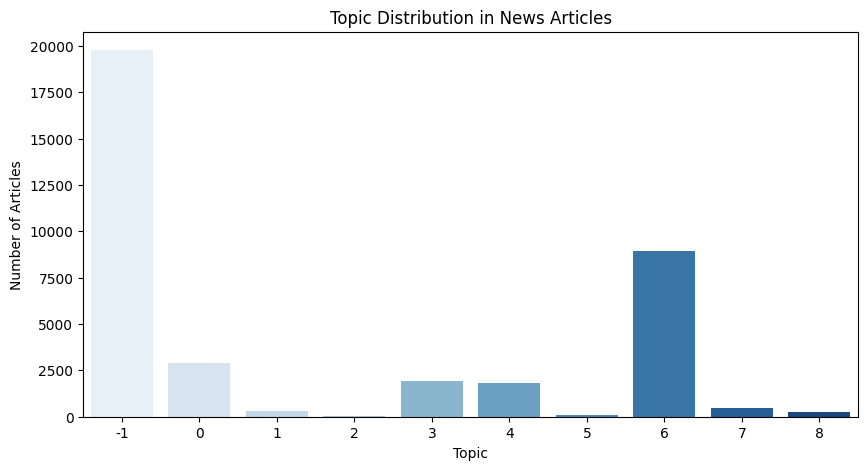

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Count how often each topic appears in news
news_topic_counts = news['topic'].value_counts().sort_index()

# 🔹 Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=news_topic_counts.index, y=news_topic_counts.values, palette="Blues")
plt.title("Topic Distribution in News Articles")
plt.xlabel("Topic")
plt.ylabel("Number of Articles")
plt.show()


<Figure size 1400x700 with 0 Axes>

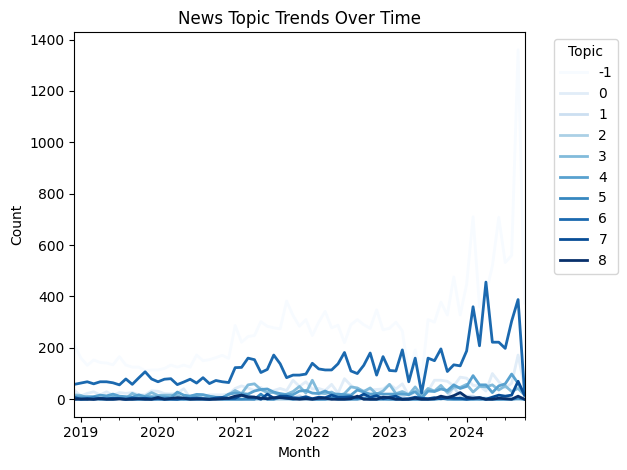

In [120]:
# 🔹 Ensure datetime format
news["Date"] = pd.to_datetime(news["Date"])

# 🔹 Group by month and topic
news['month'] = news['Date'].dt.to_period('M')
news_topic_trends = news.groupby(['month', 'topic']).size().unstack(fill_value=0)

# 🔹 Plot topic trends
plt.figure(figsize=(14, 7))
news_topic_trends.plot(colormap="Blues", linewidth=2)
plt.title("News Topic Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
